# Mixer benchmark

Benchmark mimicking mixing audio in VoIP setting. There's is a number of conferences running on a server. Each conference has a main thread for mixing audio, and each participant has a thread handling audio IO and codecs. 

Here, participant threads generate audio packets and put it in a slot for conference thread to pick up. Conference thread has to pick a packet from all participants to be able to proceed.

Mostly IO bound, but there's a lot of synchronisation required.

Executed on Cael.

# Setup

### Find paths

In [1]:
repo_path = !git rev-parse --show-toplevel
assert (len(repo_path) == 1)

exec_path = repo_path[0] + "/_build/default/test/benchmark_mixer.exe"

### Run benchmark function

In [2]:
import numpy as np
import json

def run(scheduler,domains=-1,spawners=-1):
    cmd = exec_path + " -scheduler " + scheduler + " -num-of-domains " + str(domains) + " -num-of-spawners " + str(spawners)
    output = !$cmd
    assert (output[0][0:5] == "start")
    assert (output[-1][0:4] == "done")
    output = output[1:-1]
    
    grouped_time = [] 
    grouped_minor_words = []
    grouped_major_words = [] 
    grouped_breach_rate = []
    grouped_per_mixer_time = []
    
    for i in range(1,round(len(output)/6)):
        index = i*6
        
        assert (output[index][:10] == "iteration:")
        #iteration = int(output[index][10:])
        
        assert (output[index+1][:5] == "time:")
        time = int(output[index+1][5:]) 
        grouped_time.append(time)
        
        assert (output[index+2][:12] == "minor_words:")
        minor_words = int(output[index+2][12:]) 
        grouped_minor_words.append(minor_words)
        
        assert (output[index+3][:12] == "major_words:")
        major_words = int(output[index+3][12:]) 
        grouped_major_words.append(major_words)
        
        assert (output[index+4][:14] == "breaches-rate:")
        breach_rate = int(output[index+4][14:]) 
        grouped_breach_rate.append(breach_rate)
        
        
        
        assert (output[index+5][:20] == "avg-processing-time:")
        per_mixer_time = int(output[index+2][20:])
        grouped_per_mixer_time.append(per_mixer_time)
        
    avg_time = np.mean(grouped_time)
    avg_minor_words = np.mean(grouped_minor_words)
    avg_major_words = np.mean(grouped_major_words)
    avg_breach_rate = np.mean(grouped_breach_rate)
    avg_per_mixer_time = np.mean(grouped_per_mixer_time)
    
    return (avg_time, avg_minor_words, avg_major_words, avg_breach_rate, avg_per_mixer_time)

### Plotting

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

# Experiment: domains vs mixers

## Data collection

In [4]:
param_space = range(1,10)

fifo = []
for i in param_space:
    fifo.append(run("FIFO", domains=10, spawners=10+2*i))

lifo = []
for i in param_space:
    lifo.append(run("LIFO", domains=10, spawners=10+2*i))
    
x = list(param_space)

In [5]:
lifo

[(5209.7, 1832924129.6, 12929899.1, 10.9, 59.6),
 (5985.5, 2454150411.5, 17434894.7, 50.3, 41.5),
 (6611.9, 2804395641.0, 21923017.5, 75.5, 31.0),
 (8179.9, 3997980803.9, 25593743.9, 203.6, 43.9),
 (9830.4, 4600478480.0, 31330434.2, 295.2, 50.0),
 (10857.5, 5476976633.8, 39987733.0, 329.5, 43.8),
 (13170.6, 6883243652.0, 51392778.6, 418.9, 52.0),
 (14281.2, 8415805087.3, 59073457.8, 440.7, 187.3),
 (14595.4, 8354162217.6, 59599078.1, 434.7, 197.6)]

In [6]:
fifo

[(5163.9, 1430324087.5, 11086177.7, 0.3, 32.5),
 (5291.3, 1597802721.9, 12284555.1, 0.5, 41.9),
 (6371.7, 2196507099.0, 17888464.0, 2.1, 39.0),
 (7512.7, 2607465921.8, 23299391.7, 1.8, 51.8),
 (7452.4, 2822828663.7, 25992680.2, 2.2, 43.7),
 (8549.1, 2985449140.8, 31663727.8, 1.4, 40.8),
 (9666.9, 3328102372.4, 39183090.3, 2.9, 42.4),
 (10330.6, 3551945511.1, 43317480.3, 8.2, 61.1),
 (10569.5, 3708394114.1, 47077120.7, 10.7, 64.1)]

# Analysis

In [7]:
fifo_time = [v[0] for v in fifo]
lifo_time = [v[0] for v in lifo]

In [9]:
X = [10+2*v for v in x]

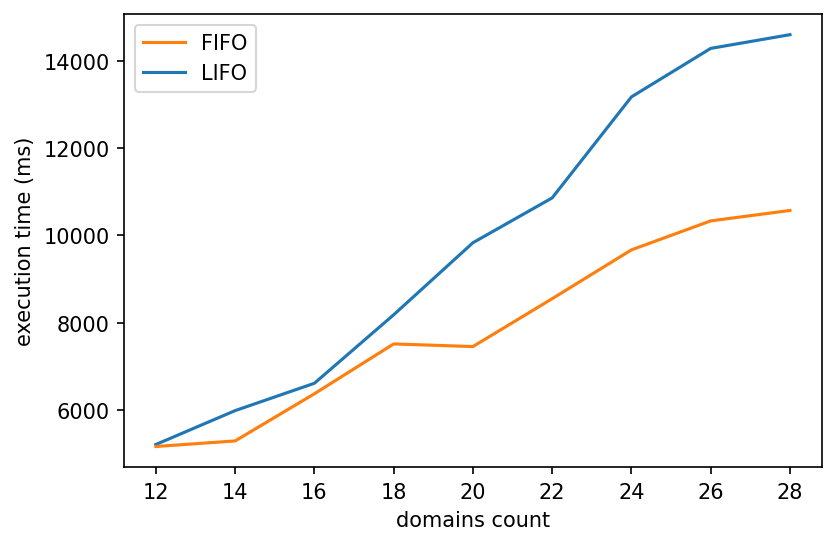

In [12]:
fig, ax = plt.subplots()
line_lifo, = ax.plot(X, lifo_time, label='LIFO')
line_fifo, = ax.plot(X, fifo_time, label='FIFO')
ax.legend(handles=[line_fifo, line_lifo])

plt.xlabel('domains count')
plt.ylabel('execution time (ms)')
plt.show()

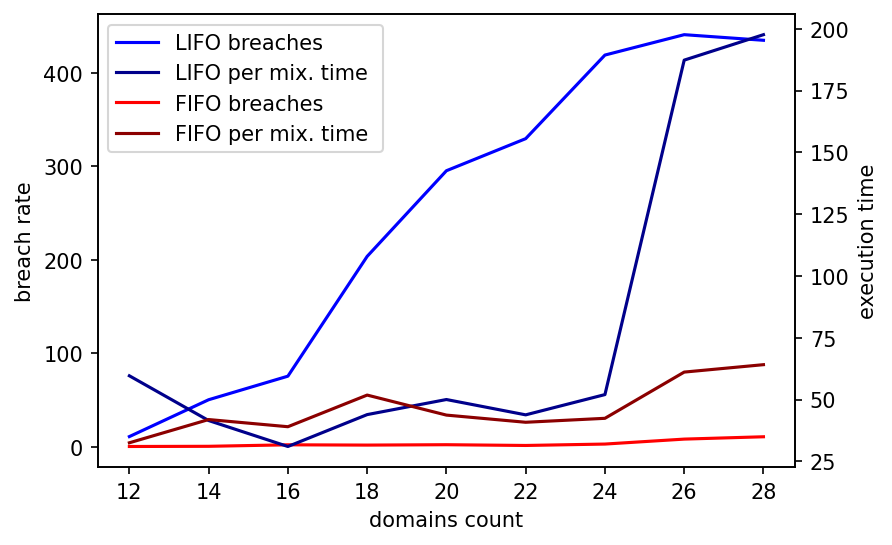

In [35]:
fifo_breach_rate = [v[3] for v in fifo]
lifo_breach_rate = [v[3] for v in lifo]

fifo_per_mixer_time = [v[4] for v in fifo]
lifo_per_mixer_time = [v[4] for v in lifo]

fig, ax = plt.subplots()
line_lifo, = ax.plot(X, lifo_breach_rate, label='LIFO breaches', color='blue')
line_fifo, = ax.plot(X, fifo_breach_rate, label='FIFO breaches', color='red')
plt.ylabel('breach rate')

plt.xlabel('domains count')

ax2 = ax.twinx()
line_lifo2, = ax2.plot(X, lifo_per_mixer_time, label='LIFO per mix. time', color='darkblue')
line_fifo2, = ax2.plot(X, fifo_per_mixer_time, label='FIFO per mix. time ', color='darkred')

ax.legend(handles=[line_lifo, line_lifo2,line_fifo, line_fifo2])
plt.ylabel('execution time')

plt.show()

# GC

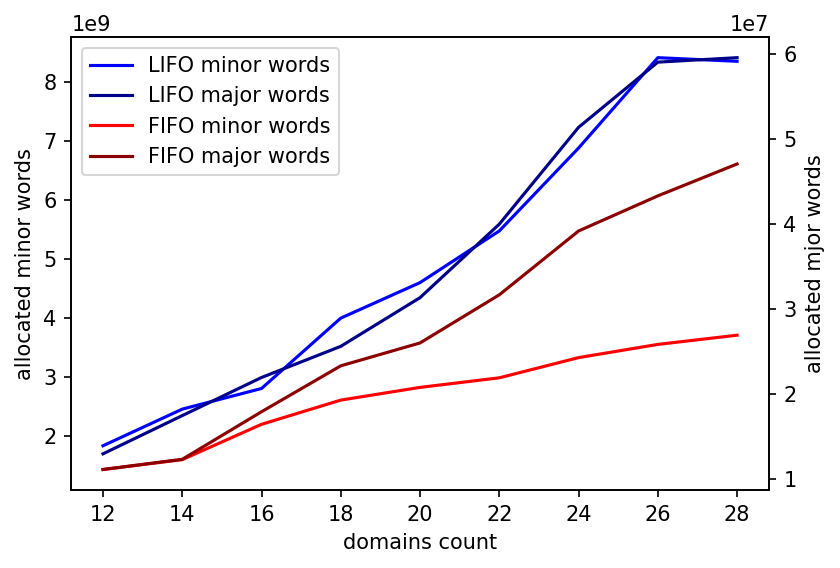

In [36]:
fifo_minor = [v[1] for v in fifo]
lifo_minor = [v[1] for v in lifo]

fifo_major = [v[2] for v in fifo]
lifo_major = [v[2] for v in lifo]

fig, ax = plt.subplots()
line_lifo, = ax.plot(X, lifo_minor, label='LIFO minor words', color='blue')
line_fifo, = ax.plot(X, fifo_minor, label='FIFO minor words', color='red')
plt.ylabel('allocated minor words')

plt.xlabel('domains count')

ax2 = ax.twinx()
line_lifo2, = ax2.plot(X, lifo_major, label='LIFO major words', color='darkblue')
line_fifo2, = ax2.plot(X, fifo_major, label='FIFO major words', color='darkred')

ax.legend(handles=[line_lifo, line_lifo2,line_fifo, line_fifo2])
plt.ylabel('allocated mjor words')

plt.show()